In [ ]:
!pip install -qU diffusers transformers huggingface_hub controlnet_aux

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Outpainting

Outpainting extends an image beyond its original boundaries, allowing us to add, replace, or modify visual elements in an image while preserving the original image.

## Image preparation

In [3]:
import random
import requests
import torch
from controlnet_aux import ZoeDetector
from PIL import Image, ImageOps

from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    StableDiffusionXLControlNetPipeline,
    StableDiffusionXLInpaintPipeline,
)


def scale_and_paste(original_image):
    aspect_ratio = original_image.width / original_image.height

    if original_image.width > original_image.height:
        new_width = 1024
        new_height = round(new_width / aspect_ratio)
    else:
        new_height = 1024
        new_width = round(new_height * aspect_ratio)

    resized_image = original_image.resize((new_width, new_height), Image.LANCZOS)
    white_background = Image.new("RGBA", (1024, 1024), 'white')
    x = (1024 - new_width) // 2
    y = (1024 - new_height) // 2
    white_background.paste(resized_image, (x,y), resized_image)

    return resized_image, white_background


original_image = Image.open(
    requests.get(
        "https://huggingface.co/datasets/stevhliu/testing-images/resolve/main/no-background-jordan.png",
        stream=True,
    ).raw
).convert('RGBA')

resized_img, white_bg_img = scale_and_paste(original_image)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
original_image

Output hidden; open in https://colab.research.google.com to view.

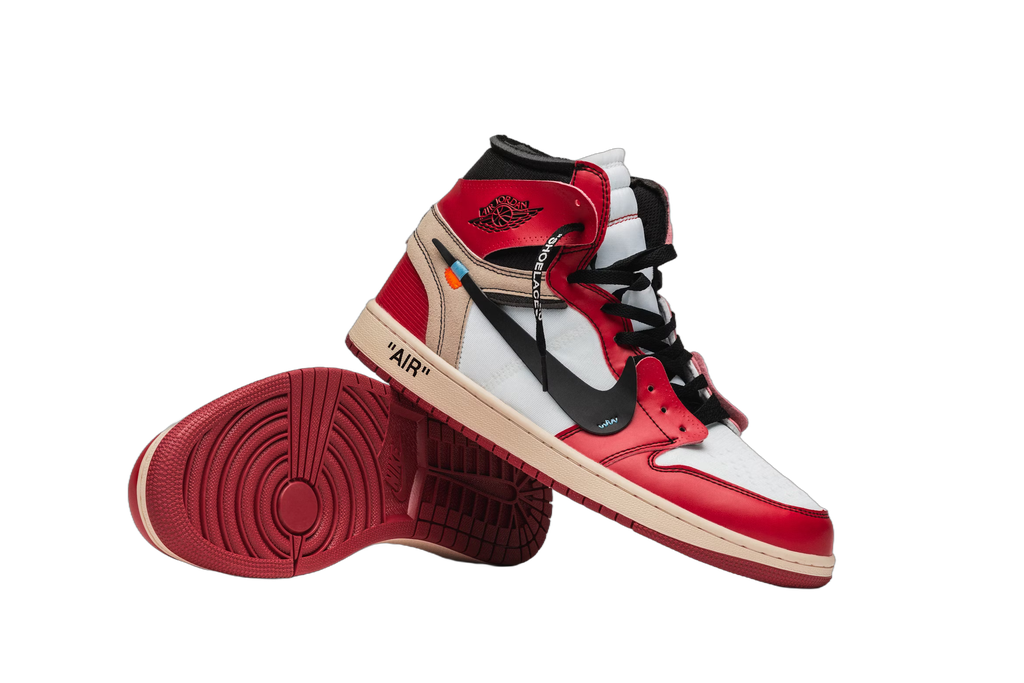

In [5]:
resized_img

To avoid adding unwanted extra details, we will use the ZoeDepth estimator to provide additional guidance during generation and to ensure the shoes remain consistent with the original image.

In [ ]:
zoe = ZoeDetector.from_pretrained('lllyasviel/Annotators')
image_zoe = zoe(white_bg_img, detect_resolution=512, image_resolution=1024)
image_zoe

## Outpaint

In [ ]:
controlnets = [
    ControlNetModel.from_pretrained(
        'destitech/controlnet-inpaint-dreamer-sdxl',
        torch_dtype=torch.float16,
        variant='fp16'
    ),
    ControlNetModel.from_pretrained(
        'diffusers/controlnet-zoe-depth-sdxl-1.0',
        torch_dtype=torch.float16,
    )
]

vae = AutoencoderKL.from_pretrained(
    'madebyollin/sdxl-vae-fp16-fix',
    torch_dtype=torch.float16
).to('cuda')

pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
    'SG161222/RealVisXL_V4.0',
    torch_dtype=torch.float16,
    variant='fp16',
    controlnet=controlnets,
    vae=vae
).to('cuda')

In [ ]:
def generate_image(prompt, negative_prompt, inpaint_image, zoe_image, seed: int = None):
    if seed is None:
        seed = random.randint(0, 2**32 - 1)

    generator = torch.Generator('cpu').manual_seed(seed)

    image = pipeline(
        prompt,
        negative_prompt=negative_prompt,
        images=[inpaint_image, zoe_image],
        guidance_scale=6.5,
        num_inference_steps=25,
        generator=generator,
        controlnet_conditioning_scale=[0.5, 0.8],
        control_guidance_end=[0.9, 0.6],
    ).images[0]

    return image

In [ ]:
prompt = "nike air jordans on a basketball court"
negative_prompt = ""

temp_image = generate_image(
    prompt,
    negative_prompt,
    white_bg_img,
    image_zoe,
    1111,
)

Paste the original image over the initial outputained image

In [ ]:
x = (1024 - resized_img.width) // 2
y = (1024 - resized_img.height) // 2
temp_image.paste(resized_img, (x,y), resized_img)
temp_image

In [ ]:
# free up memory
pipeline = None
torch.cuda.empty_cache()

Now that we have an initial outpainted image, load the `StableDiffusionXLInpaintPipeline` with the `RealVisXL` model to generate the final outpainted image with better quality.

In [ ]:
pipeline = StableDiffusionXLInpaintPipeline.from_pretrained(
    'OzzyGT/RealVisXL_V4.0_inpainting',
    torch_dtype=torch.float16,
    vairant='fp16',
    vae=vae
).to('cuda')

Prepare a mask for the final outpainted image. To create a more natural transition between the original image and the outpainted background, blur the mask to help it blend better.

In [ ]:
mask = Image.new('L', temp_image.size)
mask.paste(resized_img.split()[3], (x,y))
mask = ImageOps.invert(mask)
final_mask = mask.point(labmda p: p > 128 and 255)

mask_blurred = pipeline.mask_processor.blur(final_mask, blur_factor=20)
mask_blurred

Create a better prompt and pass it to the `generate_outpaint` function to generate the final outpainted image.

In [ ]:
def generate_outpaint(prompt, negative_prompt, image, mask, seed: int = None):
    if seed is None:
        seed = random.randint(0, 2**32 - 1)

    generator = torch.Generator('cpu').manual_seed(seed)

    image = pipeline(
        prompt,
        negative_prompt=negative_prompt,
        image=image,
        mask_image=mask,
        num_inference_steps=30,
        generator=generator,
    ).images[0]

    return image

In [ ]:
prompt = "high quality photo of nike air jordans on a basketball court, highly detailed"
negative_prompt = ""

final_image = generate_outpaint(
    prompt,
    negative_prompt,
    temp_image,
    mask_blurred,
    111,
)
x = (1024 - resized_img.width) // 2
y = (1024 - resized_img.height) // 2
final_image.paste(resized_img, (x, y), resized_img)
final_image